<a href="https://colab.research.google.com/github/Shlok-Agarwal-7/DL-Assignment/blob/main/mnist_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import keras_tuner as kt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Split validation data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

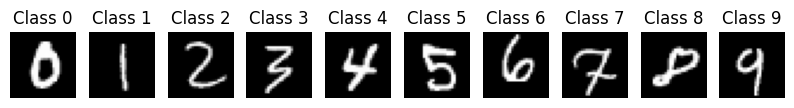

In [3]:
classes = 10
fig, axes = plt.subplots(1, classes, figsize=(10, 2))
for i in range(classes):
    ax = axes[i]
    idx = np.where(y_train == i)[0][0]
    ax.imshow(x_train[idx], cmap='gray')
    ax.set_title(f"Class {i}")
    ax.axis("off")
plt.show()

In [4]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  for i in range(hp.Int("hidden_layers", 3, 5)):
        model.add(Dense(
            units=hp.Choice(f"neurons_{i}", [32, 64, 128]),
            activation=hp.Choice("activation", ["sigmoid", "relu"]),
        ))

  model.add(Dense(10, activation='softmax'))

  learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
  optimizer_choice = hp.Choice("optimizer", ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"])

  optimizers = {
        "sgd": SGD(learning_rate),
        "momentum": SGD(learning_rate, momentum=0.9),
        "nesterov": SGD(learning_rate, momentum=0.9, nesterov=True),
        "rmsprop": RMSprop(learning_rate),
        "adam": Adam(learning_rate),
        "nadam": Nadam(learning_rate)
    }

  model.compile(optimizer=optimizers[optimizer_choice],
                loss=keras.losses.SparseCategoricalCrossentropy,
                metrics=['accuracy'])

  return model

In [5]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='mnist_tuning',
    project_name='mnist_ffnn'
)

# Search for best hyperparameters
tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val), batch_size=32)

Reloading Tuner from mnist_tuning/mnist_ffnn/tuner0.json


In [6]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [7]:
print("Best Hyperparameters:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

Best Hyperparameters:
hidden_layers: 3
neurons_0: 128
activation: sigmoid
neurons_1: 64
neurons_2: 32
learning_rate: 0.001
optimizer: adam
neurons_3: 32
neurons_4: 128


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6820 - loss: 1.1776
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9404 - loss: 0.2168
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9600 - loss: 0.1403
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9714 - loss: 0.1009
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9783 - loss: 0.0764
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9826 - loss: 0.0623
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9845 - loss: 0.0534
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9887 - loss: 0.0400
Epoch 9/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9916 - loss: 0.0310
Epoch 10/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9926 - loss: 0.0270
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.9755


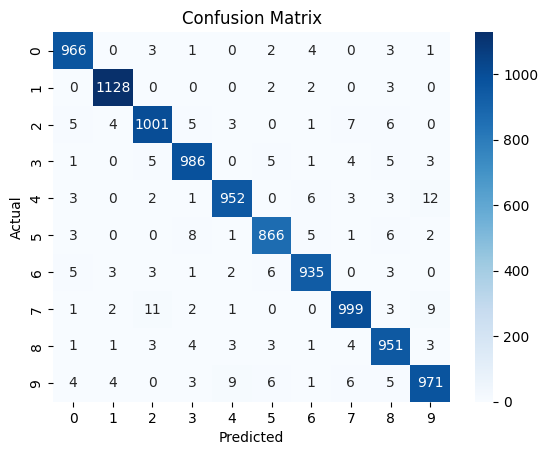

In [8]:
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(x_train, y_train, epochs=10,batch_size=32, verbose=1)

y_pred = np.argmax(best_model.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6774 - loss: 1.2111
Epoch 2/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9408 - loss: 0.2216
Epoch 3/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9605 - loss: 0.1429
Epoch 4/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9705 - loss: 0.1039
Epoch 5/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9768 - loss: 0.0815
Epoch 6/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9813 - loss: 0.0663
Epoch 7/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9857 - loss: 0.0496
Epoch 8/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9877 - loss: 0.0450
Epoch 9/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9903 - loss: 0.0357
Epoch 10/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9937 - loss: 0.0247
Epoch 11/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9951 - loss: 0.0192
Epoch 12/30
1688/1688 ━━━━━━━━

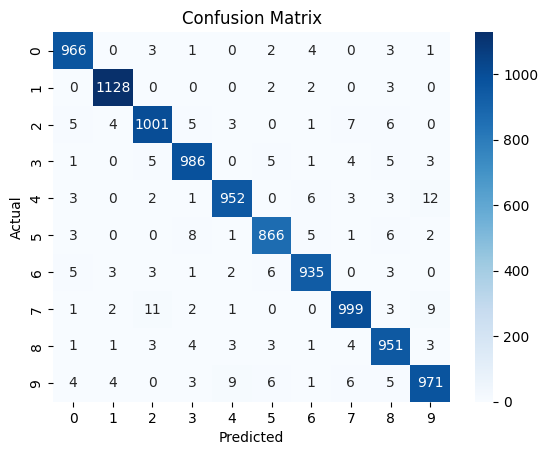

In [9]:
best_model_1 = tuner.hypermodel.build(best_hps)
best_model_1.fit(x_train, y_train, epochs=30,batch_size=32, verbose=1)

y_pred = np.argmax(best_model.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [3]:
def create_model(input_shape=(28, 28), hidden_layers=[128, 64, 64, 64, 32], activation='relu',
                  output_units=10, output_activation='softmax', learning_rate=0.001,
                  optimizer='adam', use_xavier=False,regularizer=None):
    """
    Creates a Sequential model with customizable parameters.

    Parameters:
    - input_shape (tuple): Shape of the input data.
    - hidden_layers (list): List of integers specifying the number of neurons in each hidden layer.
    - activation (str): Activation function for hidden layers.
    - output_units (int): Number of output units.
    - output_activation (str): Activation function for the output layer.
    - learning_rate (float): Learning rate for the optimizer.
    - optimizer (str): Choice of optimizer ('adam', 'sgd', 'rmsprop').
    - use_xavier (bool): Whether to use Xavier (GlorotUniform) weight initialization.
    - regularizer (str or None): Type of regularization ('l1', 'l2', 'l1_l2') or None.

    Returns:
    - Compiled Keras model.
    """
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))

    initializer = keras.initializers.GlorotUniform() if use_xavier else None


    reg = None
    if regularizer == 'l1':
        reg = l1(0.01)
    elif regularizer == 'l2':
        reg = l2(0.01)
    elif regularizer == 'l1_l2':
        reg = l1_l2(l1=0.01, l2=0.01)

    for units in hidden_layers:
        model.add(Dense(units, activation=activation, kernel_initializer=initializer, kernel_regularizer=reg))

    model.add(Dense(output_units, activation=output_activation, kernel_initializer=initializer))

    if optimizer == 'adam':
        optim = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optim = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optim = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Choose from 'adam', 'sgd', or 'rmsprop'.")

    model.compile(optimizer=optim,
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

# Example usage:
test_model = create_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8359 - loss: 0.5186
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9621 - loss: 0.1260
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9719 - loss: 0.0894
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9780 - loss: 0.0681
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9835 - loss: 0.0544
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9851 - loss: 0.0467
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9875 - loss: 0.0400
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9896 - loss: 0.0339
Epoch 9/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9897 - loss: 0.0323
Epoch 10/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9899 - loss: 0.0322
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.9799


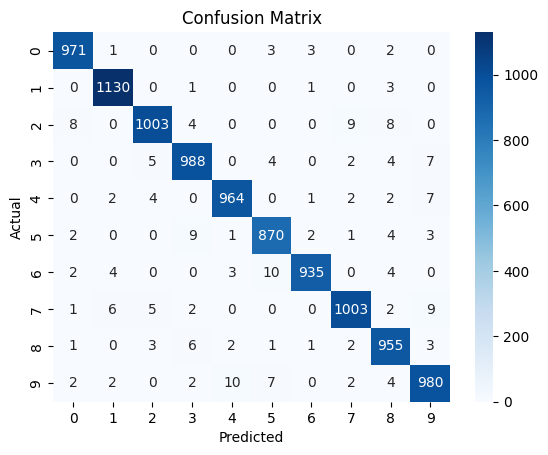

In [11]:
test_model.fit(x_train, y_train, epochs=10,batch_size=32, verbose=1)


y_pred = np.argmax(test_model.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [12]:
test_model = create_model(use_xavier=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8383 - loss: 0.5167
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9622 - loss: 0.1276
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9731 - loss: 0.0874
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9794 - loss: 0.0675
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9810 - loss: 0.0591
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9853 - loss: 0.0483
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9869 - loss: 0.0420
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9894 - loss: 0.0349
Epoch 9/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9902 - loss: 0.0307
Epoch 10/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9922 - loss: 0.0256
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Accuracy: 0.9742


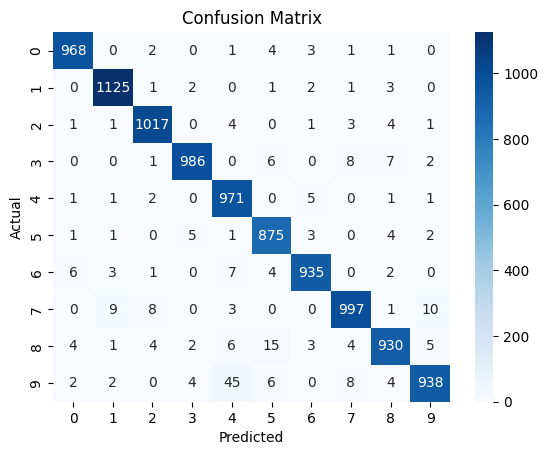

In [13]:
test_model.fit(x_train, y_train, epochs=10,batch_size=32, verbose=1)


y_pred = np.argmax(test_model.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
test_model = create_model(use_xavier=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8364 - loss: 0.5154
Epoch 2/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9635 - loss: 0.1239
Epoch 3/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9735 - loss: 0.0850
Epoch 4/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9797 - loss: 0.0661
Epoch 5/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9836 - loss: 0.0533
Epoch 6/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9854 - loss: 0.0485
Epoch 7/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9871 - loss: 0.0398
Epoch 8/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9888 - loss: 0.0353
Epoch 9/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9902 - loss: 0.0327
Epoch 10/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9923 - loss: 0.0249
Epoch 11/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9917 - loss: 0.0250
Epoch 12/30
1688/1688 ━━━━━━━━

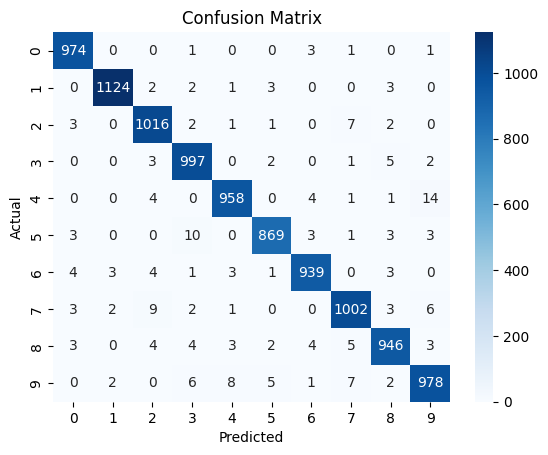

In [15]:
test_model.fit(x_train, y_train, epochs=30,batch_size=32, verbose=1)


y_pred = np.argmax(test_model.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
test_model = create_model(optimizer = 'rmsprop' , use_xavier= True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8384 - loss: 0.5136
Epoch 2/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9615 - loss: 0.1295
Epoch 3/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9714 - loss: 0.1007
Epoch 4/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9778 - loss: 0.0751
Epoch 5/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9826 - loss: 0.0667
Epoch 6/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9847 - loss: 0.0616
Epoch 7/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9844 - loss: 0.0575
Epoch 8/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9840 - loss: 0.0595
Epoch 9/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9870 - loss: 0.0534
Epoch 10/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9879 - loss: 0.0507
Epoch 11/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9874 - loss: 0.0560
Epoch 12/30
1688/1688 ━━━━━━━━

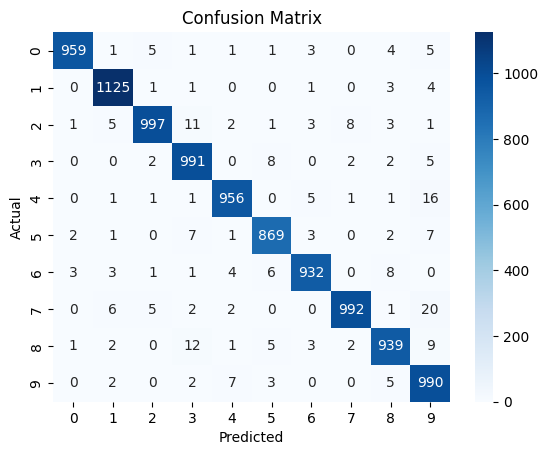

In [17]:
test_model.fit(x_train, y_train, epochs=30,batch_size=32, verbose=1)

y_pred = np.argmax(test_model.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
test_model = create_model(optimizer = 'rmsprop' , use_xavier= True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8140 - loss: 0.5951
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9575 - loss: 0.1419
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9700 - loss: 0.0971
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9783 - loss: 0.0742
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9834 - loss: 0.0559
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9859 - loss: 0.0475
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9873 - loss: 0.0404
Epoch 8/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9889 - loss: 0.0410
Epoch 9/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9899 - loss: 0.0337
Epoch 10/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9916 - loss: 0.0277
Epoch 11/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9922 - loss: 0.0236
Epoch 12/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

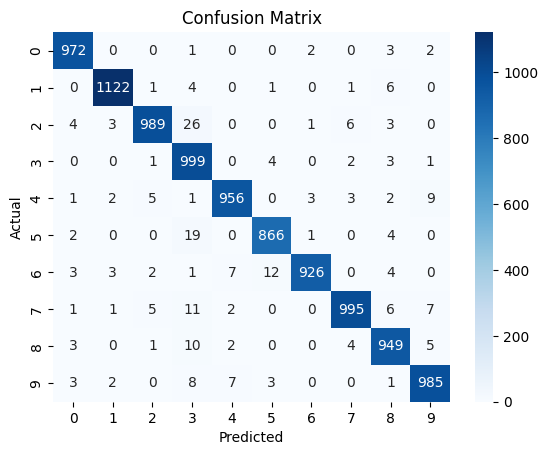

In [19]:
test_model.fit(x_train, y_train, epochs=30,batch_size=64, verbose=1)

y_pred = np.argmax(test_model.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [6]:
test_model = create_model(optimizer = 'rmsprop' , use_xavier= True ,regularizer='l2')

Epoch 1/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7765 - loss: 2.4557
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9013 - loss: 0.9235
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9171 - loss: 0.7567
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9255 - loss: 0.6825
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9304 - loss: 0.6364
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9351 - loss: 0.6011
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9381 - loss: 0.5751
Epoch 8/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9385 - loss: 0.5596
Epoch 9/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9402 - loss: 0.5459
Epoch 10/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9416 - loss: 0.5300
Epoch 11/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9434 - loss: 0.5183
Epoch 12/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

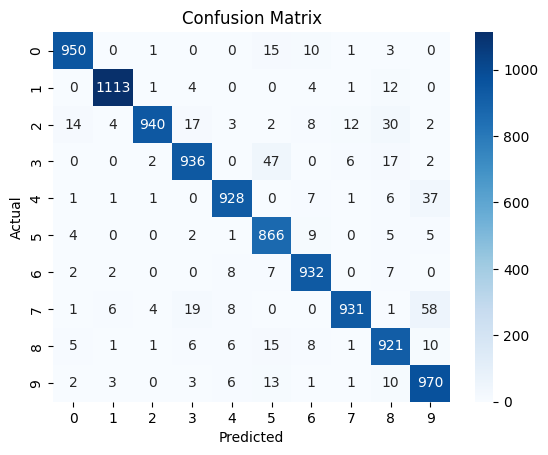

In [7]:
test_model.fit(x_train, y_train, epochs=30,batch_size=64, verbose=1)

y_pred = np.argmax(test_model.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [8]:
test_model = create_model(optimizer = 'adam' , use_xavier= True ,regularizer='l2')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7563 - loss: 2.4271
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9192 - loss: 0.8788
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9226 - loss: 0.7591
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9334 - loss: 0.6850
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9362 - loss: 0.6450
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9374 - loss: 0.6154
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9425 - loss: 0.5851
Epoch 8/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9421 - loss: 0.5676
Epoch 9/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9451 - loss: 0.5485
Epoch 10/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9453 - loss: 0.5386
Epoch 11/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9475 - loss: 0.5276
Epoch 12/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

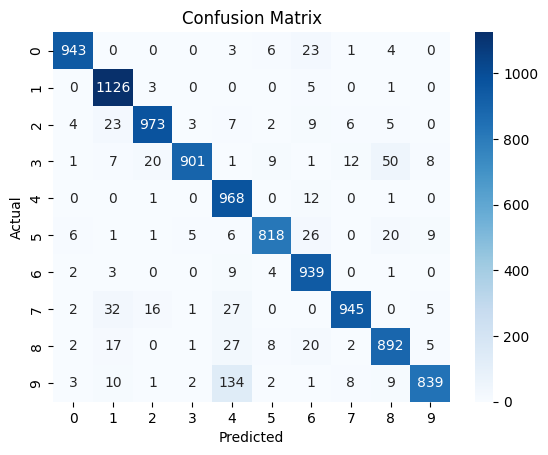

In [9]:
test_model.fit(x_train, y_train, epochs=30,batch_size=64, verbose=1)

y_pred = np.argmax(test_model.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [10]:
test_model = create_model(hidden_layers=[128,64,64,32],use_xavier=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8113 - loss: 0.6096
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9632 - loss: 0.1256
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9735 - loss: 0.0868
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9790 - loss: 0.0658
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9843 - loss: 0.0499
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9872 - loss: 0.0416
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9899 - loss: 0.0315
Epoch 8/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9897 - loss: 0.0307
Epoch 9/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9914 - loss: 0.0263
Epoch 10/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9914 - loss: 0.0259
Epoch 11/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9930 - loss: 0.0215
Epoch 12/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

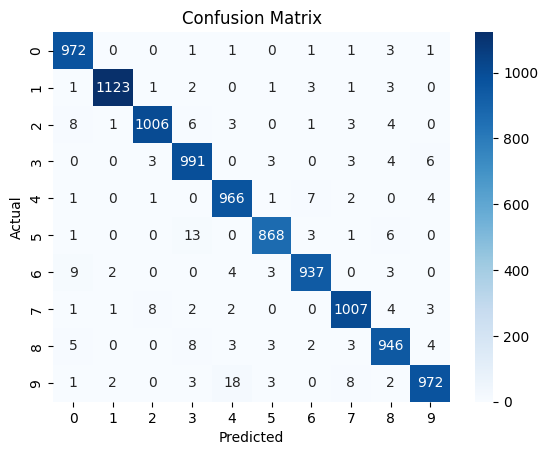

In [11]:
test_model.fit(x_train, y_train, epochs=30,batch_size=64, verbose=1)

y_pred = np.argmax(test_model.predict(x_test), axis=1)
test_acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()